In [1]:
from transformer import Encoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchsummary import summary
from tqdm import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
import sys

sys.path.append("../../src/")

# from dataset import ACIFAR10
from utils import TrainTest, PlotOutput

In [3]:
# augmentations
# x = datasets.CIFAR10(root='./data', train=True, download=True)

mean = [
    0.49139968,
    0.48215841,
    0.44653091,
]  # (x.data.transpose() / 255).reshape(3,-1).mean(-1)
std = [
    0.24703223,
    0.24348513,
    0.26158784,
]  # (x.data.transpose() / 255).reshape(3,-1).std(-1)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.ToGray(p=0.2),
        A.PadIfNeeded(40, 40, p=1),
        A.RandomCrop(32, 32, p=1),
        A.HorizontalFlip(p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, p=1),
        A.Resize(32, 32),
        ToTensorV2(),
    ]
)

test_transform = A.Compose([A.Normalize(mean=mean, std=std), ToTensorV2()])

In [4]:
class ACIFAR10(datasets.CIFAR10):
    def __init__(self, mean, std, **kwargs):
        super(ACIFAR10, self).__init__(**kwargs)
        self.mean = torch.tensor(mean).reshape(len(mean), 1, 1)
        self.std = torch.tensor(std).reshape(len(std), 1, 1)
        self.norm = A.Compose([A.Normalize(mean=mean, std=std), ToTensorV2()])

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            input_img = self.transform(image=img)["image"]

        return input_img, target, self.norm(image=img)["image"]

In [5]:
# datasets
trainset = ACIFAR10(
    mean=mean,
    std=std,
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
)

testset = ACIFAR10(
    mean=mean,
    std=std,
    root="./data",
    train=False,
    download=True,
    transform=test_transform,
)

# dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


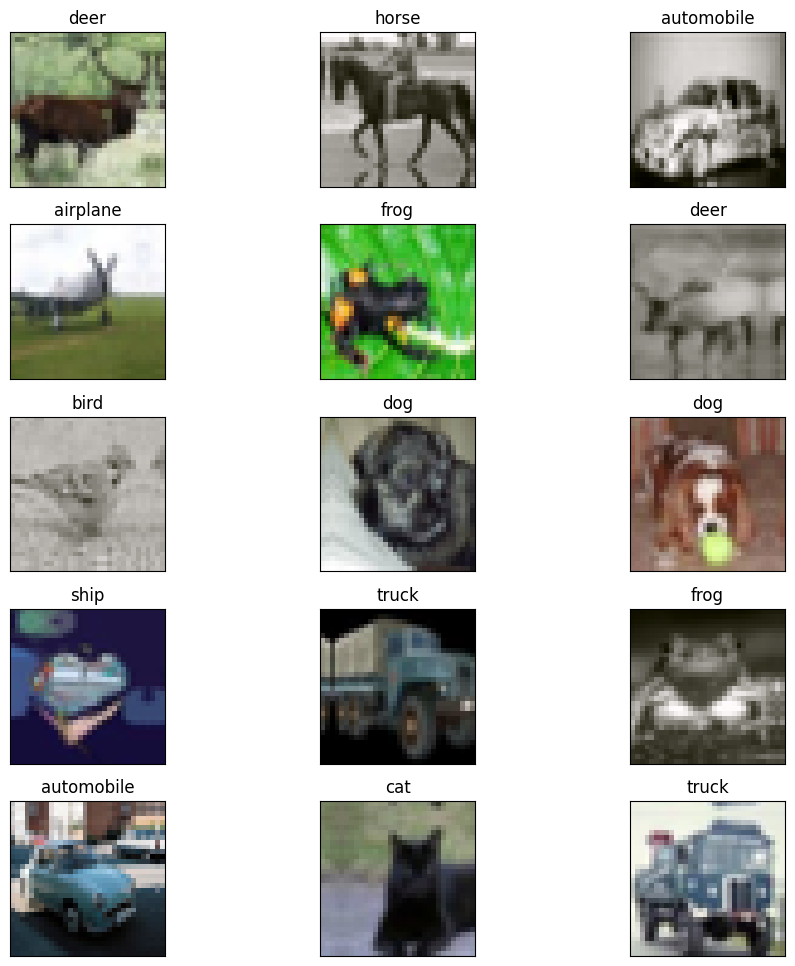

In [6]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 10))
batch_data, batch_label, _ = next(iter(train_loader))

t_std = torch.tensor(std).reshape(3, 1, 1)
t_mean = torch.tensor(mean).reshape(3, 1, 1)


for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data[i] * t_std + t_mean

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)

    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)

    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(
        self, dimension, patch_size, npatches=4, dropout=0.1, use_cls_token=False
    ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=dimension,
            kernel_size=patch_size,
            stride=patch_size,
        )

        if use_cls_token:
            num_patches = npatches + 1
            self.cls_token = nn.Parameter(torch.randn(1, 1, dimension))
            # self.mask_token = nn.Parameter(torch.zeros(1, 1, dimension)) if use_mask_token else None
        else:
            num_patches = npatches
            self.cls_token = None

        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches, dimension))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x shape: [batch, 3, 32, 32]
        self.conv shape: [batch, dimension, 8, 8]
        return [batch, 64, dimension]
        """
        batch_size, num_channels, height, width = x.shape
        embeddings = self.conv(x).flatten(2).transpose(1, 2)

        if self.cls_token is not None:
            cls_tokens = self.cls_token.expand(batch_size, -1, -1)
            embeddings = torch.cat((cls_tokens, embeddings), dim=1)

        embeddings = embeddings + self.position_embeddings
        return self.dropout(embeddings)

In [8]:
from copy import deepcopy

class Interpolate(nn.Module):
    """nn.Module wrapper for F.interpolate."""

    def __init__(self, size=None, scale_factor=None) -> None:
        super().__init__()
        self.size, self.scale_factor = size, scale_factor

    def forward(self, x):
        return F.interpolate(x, size=self.size, scale_factor=self.scale_factor)


def resize_conv3x3(in_planes, out_planes, scale=1):
    """Upsample + 3x3 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv3x3(in_planes, out_planes)
    return nn.Sequential(Interpolate(scale_factor=scale), conv3x3(in_planes, out_planes))


def resize_conv1x1(in_planes, out_planes, scale=1):
    """Upsample + 1x1 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv1x1(in_planes, out_planes)
    return nn.Sequential(Interpolate(scale_factor=scale), conv1x1(in_planes, out_planes))


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class DecoderBlock(nn.Module):
    def __init__(self, inplanes, planes, scale=1) -> None:
        super().__init__()
        self.conv1 = resize_conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv3x3(inplanes, planes, scale)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = nn.Sequential(
                resize_conv1x1(inplanes, planes, scale),
                nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        return self.relu(out)


class Decoder(nn.Module):
    def __init__(self, scale, latent_dim, outplanes=3):
        super().__init__()
        planes = [[latent_dim, latent_dim*2], 
                  [latent_dim*2, latent_dim//4], 
                  [latent_dim//4, outplanes]]
        self.decoder = nn.ModuleList([deepcopy(DecoderBlock(planes[i][0], planes[i][1], scale)) for i in range(3)])
        self.linear = nn.Linear(latent_dim, latent_dim * 4 * 4)
        
    def forward(self, x):
        batch = x.shape[0]
        x = self.linear(x)
        x = x.view(batch, -1, 4, 4)
        
        for decoder in self.decoder:
            x = decoder(x)

        return x

In [9]:
class ViT(nn.Module):
    def __init__(
        self,
        dimension,
        patch_size,
        npatches,
        nlayers,
        nheads,
        nclasses,
        use_cls_token=True,
        dropout=0.1,
    ):
        super().__init__()
        self.patch = PatchEmbedding(
            dimension=dimension,
            patch_size=patch_size,
            npatches=npatches,
            dropout=dropout,
            use_cls_token=use_cls_token,
        )
        
        """
        encoder
        """
        self.encoder = Encoder(
            number_of_layers=nlayers,
            head=nheads,
            dimension=dimension,
            dropout=dropout,
            hidden_dimension=dimension * 2,
        )

        """
        bottleneck
        """
        # distribution parameters
        self.fc_mu = nn.Linear(dimension, dimension)
        self.fc_var = nn.Linear(dimension, dimension)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        self.classification_loss = nn.CrossEntropyLoss()
        
        """
        decoder
        """
        self.decoder = Decoder(scale=2, latent_dim=dimension)

        self.ffnn = nn.Sequential(
            nn.LayerNorm(normalized_shape=dimension), nn.Linear(dimension, nclasses)
        )

    def forward(self, x, class_label, actual_image):
        """
        x: [batch, 3, 32, 32]
        x from self.encoder: [batch, seqlen, dimension]
        torch.mean(x, dim=-1): [batch, dimenion]
        """        
        x = self.patch(x)
        x = self.encoder(x)

        # get the cls token
        head = x[:, 0]

        # classification head
        classification = self.ffnn(head)

        # reconstruction head
        mu = self.fc_mu(head)
        std = self.fc_var(head)

        std = torch.exp(std / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        x_hat = self.decoder(z)

        """
        loss
        """
        # classification loss
        class_loss = self.classification_loss(classification, class_label)
        
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, actual_image)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()
        return elbo + class_loss, classification, x_hat
        
    """
    losses
    """
    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

In [10]:
device = torch.device("mps")
model = ViT(
    dimension=768,
    patch_size=4,
    npatches=64,
    nlayers=3,
    nheads=8,
    nclasses=10,
    dropout=0.01,
    use_cls_token=True,
)

# summary(model, input_size=[(3, 32, 32), torch.zeros((3, 10))], device="cpu")

8 heads 768 dimension in MultiHeadedAttention
8 heads 768 dimension in MultiHeadedAttention
8 heads 768 dimension in MultiHeadedAttention


In [11]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [12]:
def train(epoch, model, device, dataloader, optimizer):
    model.train()

    pbar = tqdm(dataloader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target, image) in enumerate(pbar):
        data = data.to(device)
        target = target.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        loss, class_pred, image_pred = model(data, target, image)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += (class_pred.argmax(-1) == target).sum().item()
        processed += len(target)

        # Display progress
        pbar.set_description(
            desc=f"Epoch: {epoch} Train: Loss={train_loss / (batch_idx + 1):0.4f} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}"
        )

    return train_loss / len(dataloader), 100 * correct / processed

In [13]:
def test(epoch, model, device, dataloader):
    model.eval()

    pbar = tqdm(dataloader)
    test_loss = 0
    correct = 0
    processed = 0

    with torch.no_grad():
        for batch_idx, (data, target, image) in enumerate(pbar):
            data = data.to(device)
            target = target.to(device)
            image = image.to(device)

            loss, class_pred, image_pred = model(data, target, image)
            test_loss += loss.item()

            correct += (class_pred.argmax(-1) == target).sum().item()
            processed += len(target)

            # Display progress
            pbar.set_description(
                desc=f"Epoch: {epoch} Test: Loss={test_loss / (batch_idx + 1):0.4f} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}"
            )

        return test_loss / len(dataloader), 100 * correct / processed

In [ ]:
EPOCHS = 500


for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}")
    train(epoch, model, device, test_loader, optimizer)
    test(epoch, model, device, test_loader)

Epoch: 0


Epoch: 0 Train: Loss=3418.6469 Batch_id=312 Accuracy=40.34: 100%|█| 313/313 [04:29<00:00,  1.16it/s]
Epoch: 0 Test: Loss=3414.5481 Batch_id=312 Accuracy=40.85: 100%|██| 313/313 [01:09<00:00,  4.49it/s]


Epoch: 1


Epoch: 1 Train: Loss=3417.5908 Batch_id=312 Accuracy=40.72: 100%|█| 313/313 [04:33<00:00,  1.14it/s]
Epoch: 1 Test: Loss=3412.6647 Batch_id=312 Accuracy=40.82: 100%|██| 313/313 [34:16<00:00,  6.57s/it]


Epoch: 2


Epoch: 2 Train: Loss=3416.5541 Batch_id=312 Accuracy=40.80: 100%|█| 313/313 [32:58<00:00,  6.32s/it]
Epoch: 2 Test: Loss=3412.8768 Batch_id=312 Accuracy=40.72: 100%|██| 313/313 [01:09<00:00,  4.49it/s]


Epoch: 3


Epoch: 3 Train: Loss=3415.9007 Batch_id=312 Accuracy=40.64: 100%|█| 313/313 [04:29<00:00,  1.16it/s]
Epoch: 3 Test: Loss=3411.9759 Batch_id=312 Accuracy=40.99: 100%|█| 313/313 [1:55:32<00:00, 22.15s/it


Epoch: 4


Epoch: 4 Train: Loss=3415.4736 Batch_id=312 Accuracy=40.72: 100%|█| 313/313 [14:16:08<00:00, 164.12s
Epoch: 4 Test: Loss=3410.9861 Batch_id=312 Accuracy=40.84: 100%|█| 313/313 [3:29:19<00:00, 40.13s/it


Epoch: 5


Epoch: 5 Train: Loss=3414.2772 Batch_id=312 Accuracy=40.63: 100%|█| 313/313 [13:25:16<00:00, 154.37s
Epoch: 5 Test: Loss=3410.7580 Batch_id=312 Accuracy=41.13: 100%|██| 313/313 [01:07<00:00,  4.62it/s]


Epoch: 6


Epoch: 6 Train: Loss=3414.1798 Batch_id=312 Accuracy=40.76: 100%|█| 313/313 [04:31<00:00,  1.15it/s]
Epoch: 6 Test: Loss=3411.1742 Batch_id=312 Accuracy=40.81: 100%|██| 313/313 [01:09<00:00,  4.49it/s]


Epoch: 7


Epoch: 7 Train: Loss=3412.9542 Batch_id=312 Accuracy=41.00: 100%|█| 313/313 [04:35<00:00,  1.14it/s]
Epoch: 7 Test: Loss=3408.9255 Batch_id=312 Accuracy=41.04: 100%|██| 313/313 [01:11<00:00,  4.40it/s]


Epoch: 8


Epoch: 8 Train: Loss=3412.2058 Batch_id=312 Accuracy=40.47: 100%|█| 313/313 [04:46<00:00,  1.09it/s]
Epoch: 8 Test: Loss=3408.6040 Batch_id=312 Accuracy=40.99: 100%|██| 313/313 [01:17<00:00,  4.03it/s]


Epoch: 9


Epoch: 9 Train: Loss=3411.8640 Batch_id=312 Accuracy=40.67: 100%|█| 313/313 [05:05<00:00,  1.02it/s]
Epoch: 9 Test: Loss=3407.6804 Batch_id=312 Accuracy=40.93: 100%|██| 313/313 [01:19<00:00,  3.95it/s]


Epoch: 10


Epoch: 10 Train: Loss=3410.9484 Batch_id=312 Accuracy=40.55: 100%|█| 313/313 [05:14<00:00,  1.01s/it
Epoch: 10 Test: Loss=3408.3990 Batch_id=312 Accuracy=40.92: 100%|█| 313/313 [01:20<00:00,  3.88it/s]


Epoch: 11


Epoch: 11 Train: Loss=3410.5307 Batch_id=312 Accuracy=40.89: 100%|█| 313/313 [05:21<00:00,  1.03s/it
Epoch: 11 Test: Loss=3407.0883 Batch_id=312 Accuracy=40.98: 100%|█| 313/313 [01:21<00:00,  3.84it/s]


Epoch: 12


Epoch: 12 Train: Loss=3409.7515 Batch_id=312 Accuracy=40.80: 100%|█| 313/313 [05:24<00:00,  1.04s/it
Epoch: 12 Test: Loss=3405.6402 Batch_id=312 Accuracy=41.05: 100%|█| 313/313 [01:21<00:00,  3.85it/s]


Epoch: 13


Epoch: 13 Train: Loss=3409.3350 Batch_id=312 Accuracy=40.74: 100%|█| 313/313 [17:11<00:00,  3.30s/it
Epoch: 13 Test: Loss=3405.7656 Batch_id=312 Accuracy=40.96: 100%|█| 313/313 [01:09<00:00,  4.51it/s]


Epoch: 14


Epoch: 14 Train: Loss=3408.5721 Batch_id=312 Accuracy=40.86: 100%|█| 313/313 [08:37<00:00,  1.65s/it
Epoch: 14 Test: Loss=3404.6409 Batch_id=312 Accuracy=40.98: 100%|█| 313/313 [01:09<00:00,  4.52it/s]


Epoch: 15


Epoch: 15 Train: Loss=3407.7578 Batch_id=312 Accuracy=40.96: 100%|█| 313/313 [04:38<00:00,  1.12it/s
Epoch: 15 Test: Loss=3403.0754 Batch_id=312 Accuracy=41.11: 100%|█| 313/313 [01:16<00:00,  4.08it/s]


Epoch: 16


Epoch: 16 Train: Loss=3407.3230 Batch_id=312 Accuracy=40.87: 100%|█| 313/313 [05:18<00:00,  1.02s/it
Epoch: 16 Test: Loss=3402.9985 Batch_id=312 Accuracy=40.95: 100%|█| 313/313 [01:20<00:00,  3.87it/s]


Epoch: 17


Epoch: 17 Train: Loss=3406.6085 Batch_id=312 Accuracy=40.74: 100%|█| 313/313 [05:27<00:00,  1.05s/it
Epoch: 17 Test: Loss=3402.4797 Batch_id=312 Accuracy=41.23: 100%|█| 313/313 [01:22<00:00,  3.78it/s]


Epoch: 18


Epoch: 18 Train: Loss=3406.1870 Batch_id=312 Accuracy=40.87: 100%|█| 313/313 [05:20<00:00,  1.02s/it
Epoch: 18 Test: Loss=3401.5429 Batch_id=312 Accuracy=41.13: 100%|█| 313/313 [01:21<00:00,  3.86it/s]


Epoch: 19


Epoch: 19 Train: Loss=3404.8290 Batch_id=312 Accuracy=40.74: 100%|█| 313/313 [06:57<00:00,  1.33s/it
Epoch: 19 Test: Loss=3401.9120 Batch_id=312 Accuracy=41.26: 100%|█| 313/313 [01:09<00:00,  4.50it/s]


Epoch: 20


Epoch: 20 Train: Loss=3404.0927 Batch_id=312 Accuracy=40.65: 100%|█| 313/313 [04:55<00:00,  1.06it/s
Epoch: 20 Test: Loss=3400.3312 Batch_id=312 Accuracy=41.23: 100%|█| 313/313 [01:19<00:00,  3.96it/s]


Epoch: 21


Epoch: 21 Train: Loss=3403.5161 Batch_id=312 Accuracy=41.07: 100%|█| 313/313 [37:09<00:00,  7.12s/it
Epoch: 21 Test: Loss=3399.6885 Batch_id=312 Accuracy=41.49: 100%|█| 313/313 [01:09<00:00,  4.49it/s]


Epoch: 22


Epoch: 22 Train: Loss=3402.8079 Batch_id=312 Accuracy=41.19: 100%|█| 313/313 [05:15<00:00,  1.01s/it
Epoch: 22 Test: Loss=3399.1297 Batch_id=312 Accuracy=41.20: 100%|█| 313/313 [01:10<00:00,  4.45it/s]


Epoch: 23


Epoch: 23 Train: Loss=3402.3116 Batch_id=312 Accuracy=41.36: 100%|█| 313/313 [04:55<00:00,  1.06it/s
Epoch: 23 Test: Loss=3398.9189 Batch_id=312 Accuracy=41.13: 100%|█| 313/313 [01:21<00:00,  3.82it/s]


Epoch: 24


Epoch: 24 Train: Loss=3401.3507 Batch_id=312 Accuracy=40.82: 100%|█| 313/313 [06:05<00:00,  1.17s/it
Epoch: 24 Test: Loss=3398.0354 Batch_id=312 Accuracy=41.33: 100%|█| 313/313 [01:40<00:00,  3.12it/s]


Epoch: 25


Epoch: 25 Train: Loss=3400.5632 Batch_id=312 Accuracy=40.73: 100%|█| 313/313 [07:36<00:00,  1.46s/it
Epoch: 25 Test: Loss=3397.7052 Batch_id=312 Accuracy=41.24: 100%|█| 313/313 [01:30<00:00,  3.47it/s]


Epoch: 26


Epoch: 26 Train: Loss=3399.7176 Batch_id=312 Accuracy=41.01: 100%|█| 313/313 [05:41<00:00,  1.09s/it
Epoch: 26 Test: Loss=3397.2173 Batch_id=312 Accuracy=41.26: 100%|█| 313/313 [01:30<00:00,  3.47it/s]


Epoch: 27


Epoch: 27 Train: Loss=3399.3392 Batch_id=312 Accuracy=41.09: 100%|█| 313/313 [05:44<00:00,  1.10s/it
Epoch: 27 Test: Loss=3396.2336 Batch_id=312 Accuracy=41.17: 100%|█| 313/313 [01:24<00:00,  3.70it/s]


Epoch: 28


Epoch: 28 Train: Loss=3398.3056 Batch_id=312 Accuracy=41.31: 100%|█| 313/313 [05:39<00:00,  1.08s/it
Epoch: 28 Test: Loss=3395.5866 Batch_id=312 Accuracy=41.30: 100%|█| 313/313 [01:25<00:00,  3.65it/s]


Epoch: 29


Epoch: 29 Train: Loss=3397.8004 Batch_id=312 Accuracy=40.81: 100%|█| 313/313 [05:48<00:00,  1.11s/it
Epoch: 29 Test: Loss=3395.2170 Batch_id=312 Accuracy=41.58: 100%|█| 313/313 [01:31<00:00,  3.43it/s]


Epoch: 30


Epoch: 30 Train: Loss=3396.8987 Batch_id=312 Accuracy=41.08: 100%|█| 313/313 [06:01<00:00,  1.15s/it
Epoch: 30 Test: Loss=3394.3501 Batch_id=312 Accuracy=41.24: 100%|█| 313/313 [01:31<00:00,  3.44it/s]


Epoch: 31


Epoch: 31 Train: Loss=3396.3490 Batch_id=312 Accuracy=41.23: 100%|█| 313/313 [05:56<00:00,  1.14s/it
Epoch: 31 Test: Loss=3393.3996 Batch_id=312 Accuracy=41.39: 100%|█| 313/313 [01:27<00:00,  3.56it/s]


Epoch: 32


Epoch: 32 Train: Loss=3395.4351 Batch_id=312 Accuracy=41.36: 100%|█| 313/313 [05:49<00:00,  1.12s/it
Epoch: 32 Test: Loss=3392.4025 Batch_id=312 Accuracy=41.52: 100%|█| 313/313 [01:36<00:00,  3.23it/s]


Epoch: 33


Epoch: 33 Train: Loss=3361.9975 Batch_id=19 Accuracy=39.84:   6%|▏ | 20/313 [00:23<05:44,  1.18s/it]